<a href="https://colab.research.google.com/github/sgulyano/aic402/blob/main/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# SPDX-License-Identifier: BSD-3-Clause

# AIC-402 Lab 1: Getting Started

CMKL University

By Sarun Gulyanon


### Goal

Introduce the fundamentals of unsupervised learning by exploring common clustering techniques available in the scikit-learn library, and demonstrate additional applications of unsupervised learning such as vector quantization for data compression.


### Outline

In this lab, we will review and explore

1. Clustering
2. Vector Quantization

----

# 0. Setting Up Working Environment

Install neceesary libraries

In [2]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

# 1. Clutering

Clustering is an unsupervised learning technique that groups data points based on similarity, without using labeled data, such that points within the same cluster are more similar to each other than to points in other clusters. Different clustering algorithms make different assumptions about cluster shape, density, and distribution.

## 1.1 Generate toy datasets

We generate several 2D datasets to highlight strengths/weaknesses of each algorithm:
- Circles: non-convex clusters
- Blobs: spherical Gaussian clusters
- No structure: uniform random

In [3]:
n_samples = 500
seed = 30

noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)

blobs = datasets.make_blobs(
    n_samples=n_samples, random_state=seed
)

# No structure (uniform random points)
rng = np.random.RandomState(seed)
no_structure = (rng.rand(n_samples, 2), None)

dataset_list = [
    ("Noisy Circles", noisy_circles),
    ("Gaussian Blobs", blobs),
    ("No Structure", no_structure),
]

len(dataset_list)

3

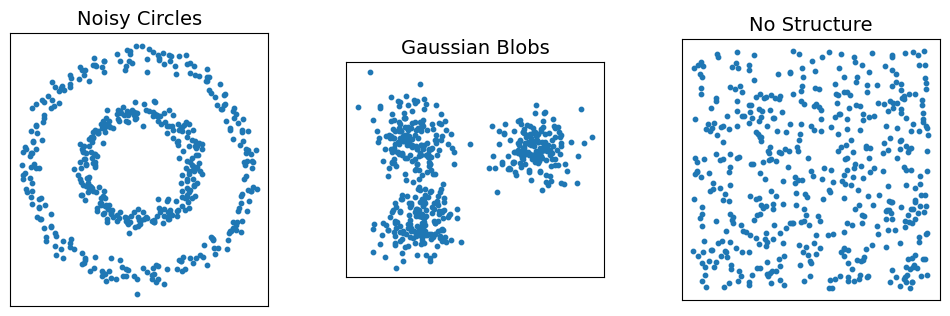

In [4]:
n_datasets = len(dataset_list)
plt.figure(figsize=(4 * n_datasets, 4))
plt.subplots_adjust(wspace=0.3)

for i, (ds_name, (X, y)) in enumerate(dataset_list):
    ax = plt.subplot(1, n_datasets, i + 1)
    ax.scatter(X[:, 0], X[:, 1], s=10)
    ax.set_title(ds_name, fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal", adjustable="box")

plt.show()

## 1.2 Clutering Algorithms
We will compare these clustering methods:
1) KMeans
2) DBSCAN
3) Spectral Clustering


In [5]:
# Dataset-specific overrides (helps keep examples readable)
dataset_params = {
    "Noisy Circles": {"n_clusters": 2, "eps": 0.25, "n_neighbors": 10},
    "Gaussian Blobs": {"n_clusters": 3, "eps": 0.25, "n_neighbors": 10},
    "No Structure": {"n_clusters": 3, "eps": 0.20, "n_neighbors": 10},
}

In [6]:
def make_algorithms(params):
    n_clusters = params["n_clusters"]
    algos = [
        ("KMeans", cluster.KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")),
        ("DBSCAN", cluster.DBSCAN(eps=params["eps"])),
        ("Spectral", cluster.SpectralClustering(
            n_clusters=n_clusters,
            affinity="nearest_neighbors",
            n_neighbors=params["n_neighbors"],
            random_state=42
        ))
    ]
    return algos

## 1.3 Cluster Visualization

The plot shows the clustering result by coloring each data point according to its assigned cluster label. Points assigned the same color belong to the same cluster, while points labeled as noise or outliers (if any) are shown in black.

In [7]:
# Color palette (add black for noise/outliers)
BASE_COLORS = [
    "#377eb8", "#ff7f00", "#4daf4a", "#f781bf", "#a65628",
    "#984ea3", "#999999", "#e41a1c", "#dede00",
]

# helper function
def plot_clusters(ax, X, labels, xlim=(-2.8, 2.8), ylim=(-2.8, 2.8)):
    unique_labels = np.unique(labels)

    # Build label -> color mapping
    label_to_color = {}
    color_cycle = list(
        islice(cycle(BASE_COLORS), max(1, len(unique_labels)))
    )

    color_idx = 0
    for lab in unique_labels:
        if lab == -1:
            continue
        label_to_color[lab] = color_cycle[color_idx % len(color_cycle)]
        color_idx += 1

    # Noise / outliers
    label_to_color[-1] = "#000000"

    colors = [label_to_color[l] for l in labels]

    ax.scatter(X[:, 0], X[:, 1], s=10, c=colors)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

The scikit-learn library makes it easy to perform clustering by providing a consistent interface across different algorithms. For most clustering methods, we simply define the clustering algorithm with its parameters, then call the `.fit()` method on the data. The resulting cluster assignments can be accessed through the model's attributes (e.g., `labels_`) or prediction methods. This unified API allows us to experiment with multiple clustering techniques using a similar workflow.

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


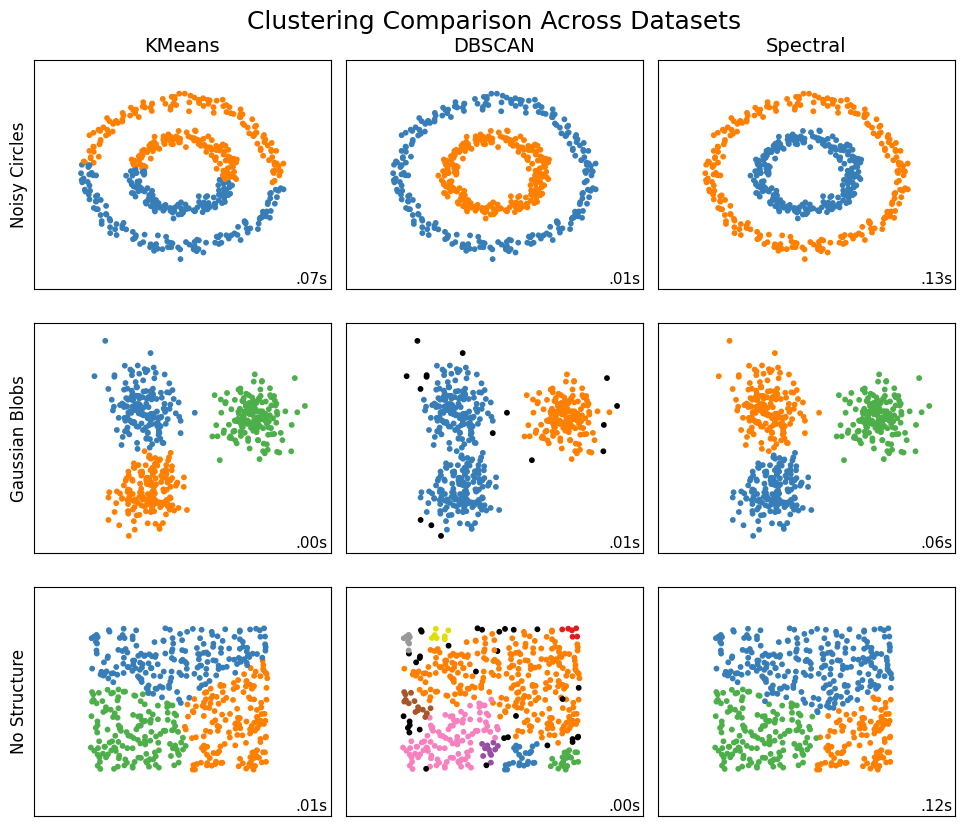

In [8]:
# Plot layout
n_rows = len(dataset_list)
algo_names = ["KMeans", "DBSCAN", "Spectral"]
n_cols = len(algo_names)

plt.figure(figsize=(3.2 * n_cols, 2.8 * n_rows))
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.92, wspace=0.05, hspace=0.15)

plot_idx = 1

for row, (ds_name, (X, y_true)) in enumerate(dataset_list):
    # Merge params
    params = dataset_params.get(ds_name, {})

    # Standardize
    X_scaled = StandardScaler().fit_transform(X)

    # Get Algorithms
    algos = make_algorithms(params)

    for col, (algo_name, model) in enumerate(algos):
        t0 = time.time()
        # perform clustering
        model.fit(X_scaled)
        t1 = time.time()

        labels = model.labels_.astype(int)


        ax = plt.subplot(n_rows, n_cols, plot_idx)
        plot_clusters(ax, X_scaled, labels)

        if row == 0:
            ax.set_title(algo_name, fontsize=14)
        if col == 0:
            ax.set_ylabel(ds_name, fontsize=12)

        ax.text(
            0.99, 0.01,
            f"{(t1 - t0):.2f}s".lstrip("0"),
            transform=ax.transAxes,
            ha="right", va="bottom",
            fontsize=11
        )

        plot_idx += 1

plt.suptitle("Clustering Comparison Across Datasets", fontsize=18)
plt.show()

# 2. Vector Quantization

Our goal is to perform vector quantization (VQ) using 24 representative vectors (codewords), where each vector corresponds to a 2 x 2 square region of the image. Since the image is in RGB, each square region is represented as a flattened vector of length 2 x 2 x 3 = 12.

Rather than implementing the vector quantization algorithm from scratch, we leverage the K-means clustering algorithm. In this formulation, each image patch is treated as a data point, and K-means is used to learn a codebook whose centroids serve as the quantization vectors.

In [9]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.datasets import face
from skimage.transform import resize

from sklearn.cluster import KMeans

# For reproducibility
np.random.seed(1000)

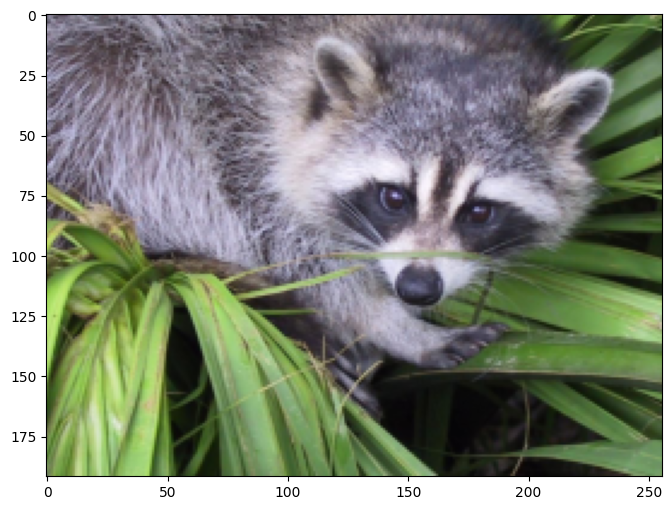

In [10]:
square_fragment_size = 2
n_qvectors = 24

# Load and resize the image
picture = resize(face(gray=False), output_shape=(192, 256), mode='reflect')

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(picture)
ax.grid(False)

plt.show()

## 2.1 Extract all non-overlapping 2x2 patches

Each patch becomes a vector of length 2*2*3 = 12.

In [11]:
# Collect all 2x2 fragments
n_fragments = int(picture.shape[0] * picture.shape[1] / (square_fragment_size ** 2))

fragments = np.zeros(shape=(n_fragments, square_fragment_size ** 2 * picture.shape[2]))
idx = 0

for i in range(0, picture.shape[0], square_fragment_size):
    for j in range(0, picture.shape[1], square_fragment_size):
        fragments[idx] = picture[i:i + square_fragment_size,
                          j:j + square_fragment_size, :].flatten()
        idx += 1

## 2.2 Learn a codebook with KMeans

KMeans finds n_qvectors representative patch vectors (cluster centers).

In [12]:
# Perform the quantization
km = KMeans(n_clusters=n_qvectors, random_state=1000)
km.fit(fragments)

qvs = km.predict(fragments)

## 2.3 Reconstruct (quantize) the image using the codebook

In [13]:
# Build the quantized image
qv_picture = np.zeros(shape=(192, 256, 3))
idx = 0

for i in range(0, 192, square_fragment_size):
    for j in range(0, 256, square_fragment_size):
        qv_picture[i:i + square_fragment_size,
                    j:j + square_fragment_size, :] = \
            km.cluster_centers_[qvs[idx]].\
                reshape((square_fragment_size, square_fragment_size, 3))
        idx += 1

## 2.4 Plot result

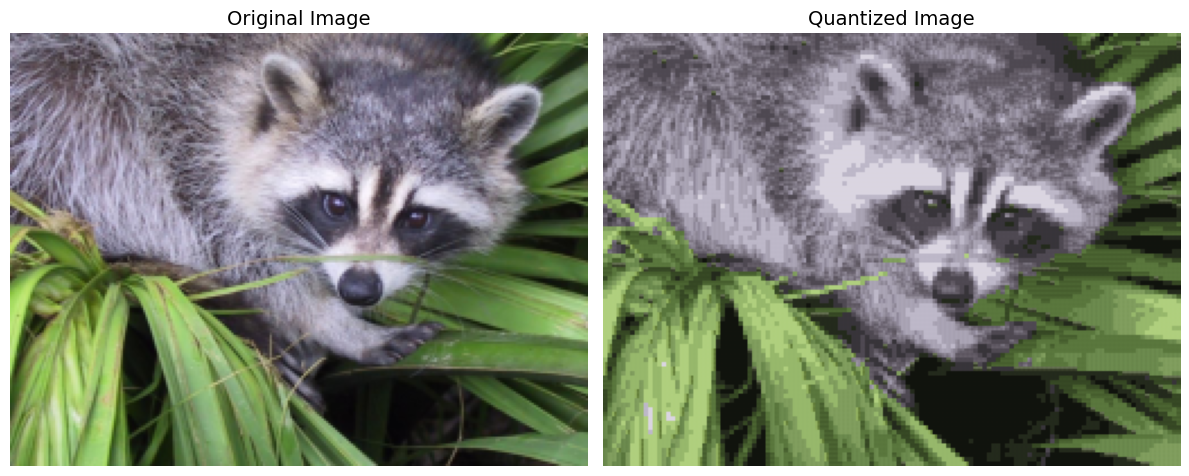

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].imshow(picture)
ax[0].set_title("Original Image", fontsize=14)
ax[0].axis("off")

ax[1].imshow(qv_picture)
ax[1].set_title("Quantized Image", fontsize=14)
ax[1].axis("off")

plt.tight_layout()
plt.show()

Entropy measures the amount of information in an image. We compute it from the histogram of pixel intensities by first converting the histogram into a probability distribution, then applying Shannon’s formula

$$ H = -\sum_i p(i)\log_2 p(i). $$

A more spread-out histogram gives higher entropy, while quantization concentrates values and leads to lower entropy.

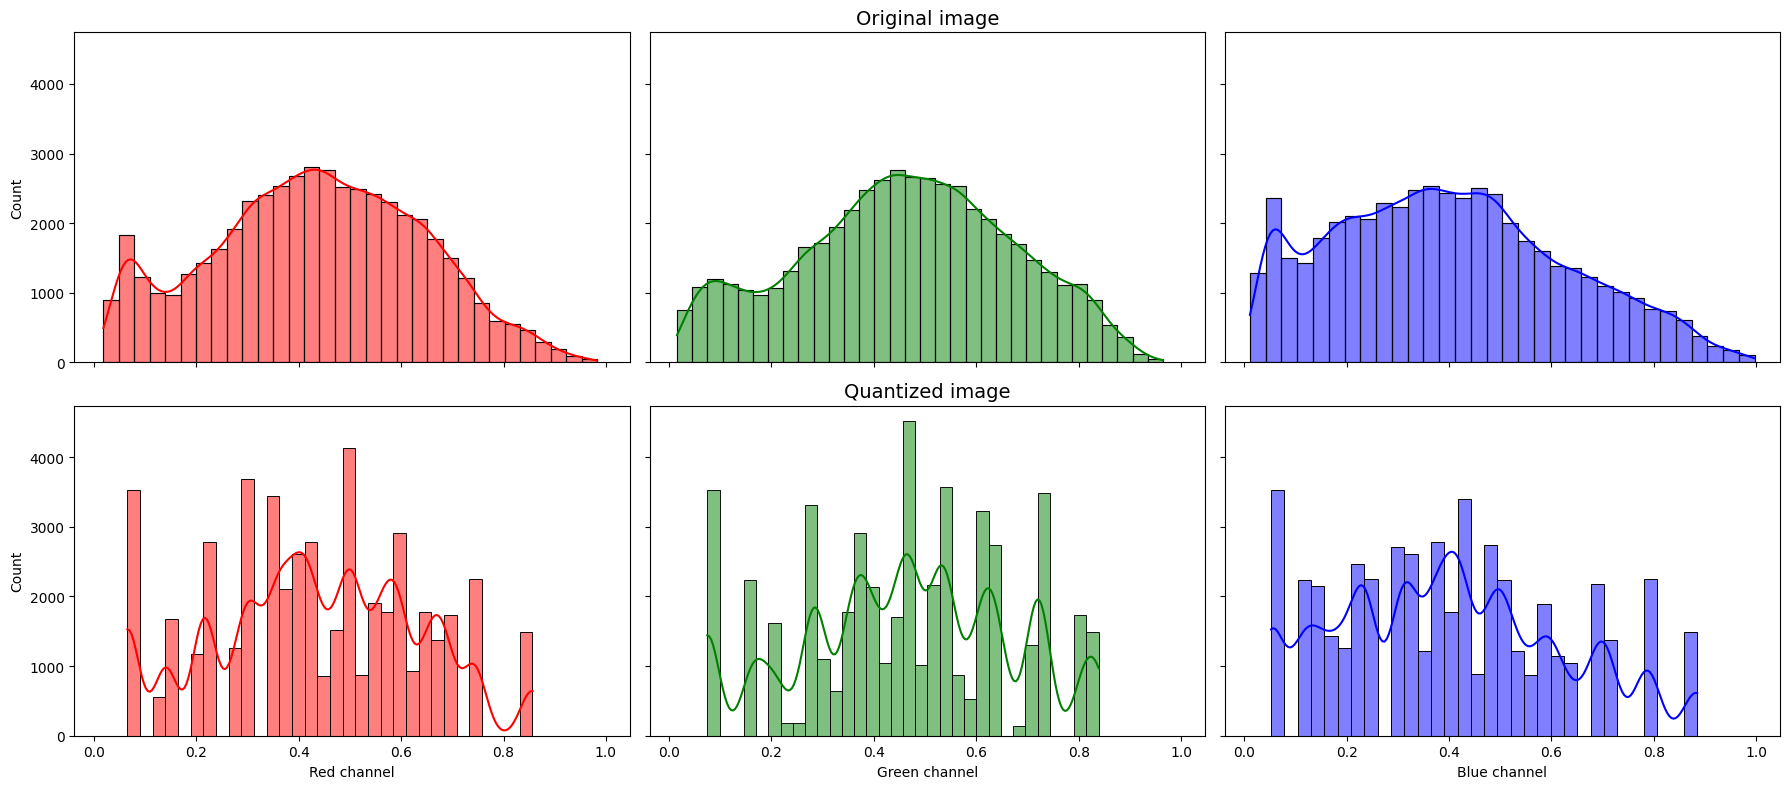

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)

# Original image
sns.histplot(picture[:, :, 0].flatten(), bins=32, kde=True, ax=ax[0, 0], color='r')
sns.histplot(picture[:, :, 1].flatten(), bins=32, kde=True, ax=ax[0, 1], color='g')
sns.histplot(picture[:, :, 2].flatten(), bins=32, kde=True, ax=ax[0, 2], color='b')

# Quantized image
sns.histplot(qv_picture[:, :, 0].flatten(), bins=32, kde=True, ax=ax[1, 0], color='r')
sns.histplot(qv_picture[:, :, 1].flatten(), bins=32, kde=True, ax=ax[1, 1], color='g')
sns.histplot(qv_picture[:, :, 2].flatten(), bins=32, kde=True, ax=ax[1, 2], color='b')

ax[0, 1].set_title("Original image", fontsize=14)
ax[1, 1].set_title("Quantized image", fontsize=14)

ax[1, 0].set_xlabel("Red channel")
ax[1, 1].set_xlabel("Green channel")
ax[1, 2].set_xlabel("Blue channel")

plt.tight_layout()
plt.show()

In [16]:
# Compute the entropy of the red channels
hist_original, _ = np.histogram(picture[:, :, 0].flatten() * 255.0, bins=256)
hist_q, _ = np.histogram(qv_picture[:, :, 0].flatten() * 255.0, bins=256)

p_original = hist_original / np.sum(hist_original)
H_original = -np.sum(p_original * np.log2(p_original + 1e-8))

p_q = hist_q / np.sum(hist_q)
H_q = -np.sum(p_q * np.log2(p_q + 1e-8))

print('Original entropy: {0:.3f} bits - Quantized entropy: {1:.3f} bits'.format(H_original, H_q))

Original entropy: 7.720 bits - Quantized entropy: 5.649 bits


Vector quantization reduces the image's information content by about 1−(7.720/5.649) = 27%, making it theoretically ~1.37x more compressible at the cost of some visual detail.

---